# Cloud Droplet Concentration Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import pandas as pd
from scipy.io import netcdf
from netCDF4 import Dataset
import statistics
import matplotlib.style
matplotlib.style.use('classic')
import os
os.chdir('C:/Users/yashg/Documents/Cloud_Data_Files/')
from IPython.display import display, Image

Data generated using grid box methodology <br>
Data generated from CDC_DataProcessing.ipynb (https://github.com/yashgokhale/Data-Analysis-ML-of-Cloud-Data/blob/master/CDC_DataProcessing.ipynb)

In [2]:
data=pd.read_csv('data_23072020.csv')

### Parameters of interest

The input file has the following units <br>

| Parameter| Unit   |
|------|------|
|   Water Content | g/m3|
| Height|m|
|Velocity|m/s|
|Spectral width|m/s|
|Reflectivity|dBZ|
|Extinction|1/km|
|Temperature|K|
|CCN|1/cm3|


In [3]:
temp=data['Temperature']
lwc=data['LWC']
w=data['Velocity_SD']*0.6
ex=data['Extinction']
ccn=data['CCN']
ext=data['Extinction']
#ref=10**(data['Reflectivity']/10)
ref=10**((data['Reflectivity']-180)/10)
ccn=data['CCN']

Note: Velocity is considered as (standard deviation of the velocity*0.6) as per https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2009JD013233 <br>
Reflectivity is converted from dbZ to ${mm}^6/{m}^3$

## Calculation of Cloud Droplet Concentration:
Three primary methods are used, taking variables, extracted from multiple radar Data files
1. Pinksy correlation (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2012JD017753)
2. Fan correlation (https://www.atmos-meas-tech.net/12/5817/2019/)
3. Lidar correlation (https://reader.elsevier.com/reader/sd/pii/S1464190900001519?token=B34C288D5897B56E1309FBA98D7B1E60B8754C39F4CBA6EEFAE61765ACA19096778BD347C492D4BB104C2ACCFEDC2674) and Lidar Equation

### Section 1: Pinsky correlation-
$S_{max}={C_3}^{\frac{2}{2+k}}{N_o}^{\frac{-1}{2+k}}{w}^{\frac{3}{4+2k}}$ <br>
$N={C_3}^{\frac{2k}{2+k}}{N_o}^{\frac{2}{2+k}}{w}^{\frac{3k}{4+2k}}$

In [4]:
#Parameters
A=8.07131
B=1730.63
C=233.426
l=2260000 #J/kg
a_cond=0.022 #W/m/K
a_water=5.5575 #W/m/K
D=0.399*10**-4 #m^2/s
Ra=287 #J/deg/kg
Rv=461 #J/deg/kg
qv=0.04 #kg/kg
rhow=1000 #kg/m3
rhoa=1.225 #kg/m3
g=9.8 #m2/s
cp=1000 #J/kg
C1=1.058 

Defining the functions:

In [5]:
def vaporpressure(temp):
    p=10**(A-(B)/(C+temp))
    p=p*133.322
    return p #in pascals

def constants(temp):
    vp=vaporpressure(temp-273.15)
    k=(1.52E-11)*(temp)**3-(4.8574E-8)*(temp)**2+1.0184E-04*(temp)-3.9333E-04
    F=(rhow*(l)**2/k/Rv/(temp)**2)+(rhow*Rv*(temp)/vp/D)
    A1=(g/Ra/temp*((l*Ra/(cp*Rv*temp))-1))
    A2=1/qv+((l)**2/cp/Rv/(temp)**2)
    return k,F,A1,A2

def C3(temp):
    k,F,A1,A2=constants(temp)
    a=C1*(F*A1/3)**0.75
    b=(3*rhoa/4/np.pi/rhow/A2)**0.5
    return a*b

def CDC_pinsky(temp,No,v,k):
    C=C3(temp)/10
    a=C**(2*k/(2+k))
    b=(No)**(2/(2+k))
    c=np.abs(v)**(3*k/(4+2*k))
    return a*b*c

def Smax(temp,No,v,k):
    C=C3(temp)/10
    a=C**(2/(2+k))
    b=(No)**(-1/(2+k))
    c=np.abs(v)**(3/(4+2*k))
    return a*b*c

#### Artificial Data Plots
Taken from Pinsky et al (https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2012JD017753)

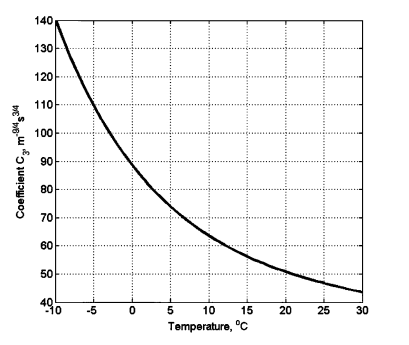

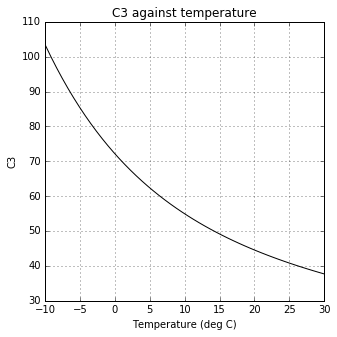

In [6]:
display(Image(filename='graphs2.png'))
t=np.linspace(-10,30,50)
c3t=C3(t+273.15)
plt.figure(facecolor='white',figsize=(5,5))
plt.plot(t,c3t,'k-')
plt.xlabel('Temperature (deg C)')
plt.ylabel('C3')
plt.title('C3 against temperature')
plt.grid()
plt.show()

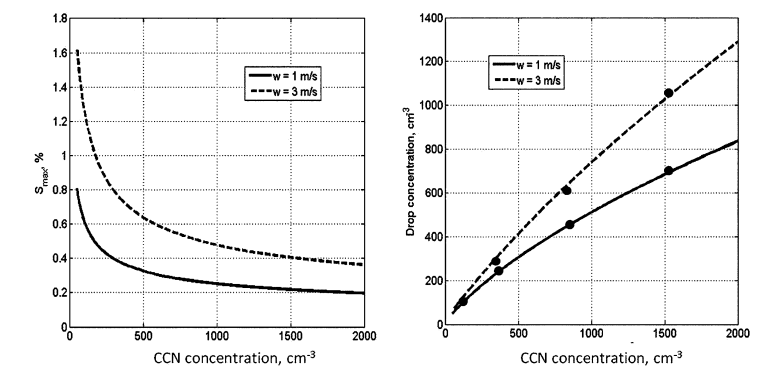

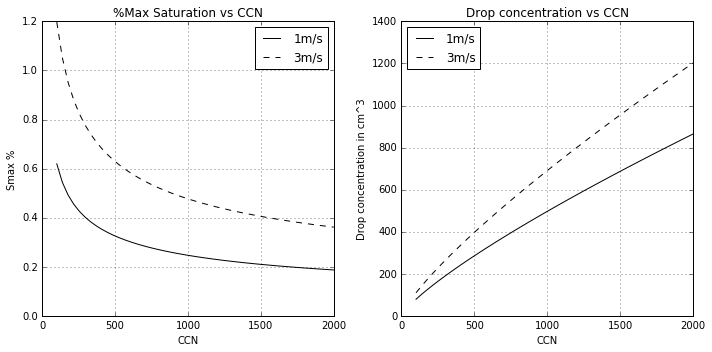

In [7]:
display(Image(filename='graphs1.png'))
no=np.linspace(100,2000)
ss=Smax(10+273.15,no,1,0.5)
ss2=Smax(10+273.15,no,3,0.5)
ccnm=CDC_pinsky(10+273.15,no,1,0.5)
ccnm2=CDC_pinsky(10+273.15,no,3,0.5)
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,facecolor='white',figsize=(10,5))
ax1.plot(no,ss,'k-',label='1m/s')
ax1.plot(no,ss2,'k--',label='3m/s')
ax1.set_xlabel('CCN')
ax1.set_ylabel('Smax %')
ax1.legend()
ax1.grid()
ax1.set_title('%Max Saturation vs CCN')
ax2.plot(no,ccnm,'k-',label='1m/s')
ax2.plot(no,ccnm2,'k--',label='3m/s')
ax2.set_xlabel('CCN')
ax2.set_ylabel('Drop concentration in cm^3')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Drop concentration vs CCN')
fig.tight_layout()

#### Actual Data Plots

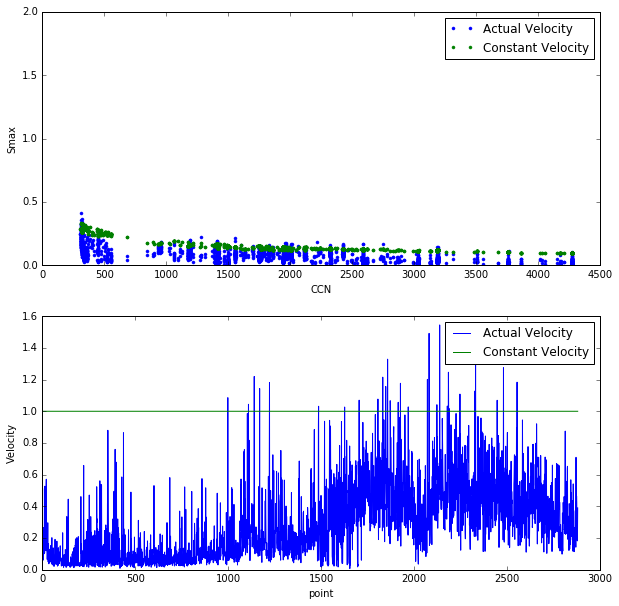

In [8]:
sm=Smax(temp,ccn,w,0.5)
fig,(ax1,ax2)=plt.subplots(2,figsize=(10,10),facecolor='white')
ax1.plot(ccn,sm,'.',label='Actual Velocity')
ax1.plot(ccn,Smax(temp,ccn,1,0.3),'.',label='Constant Velocity')
ax1.set(xlabel='CCN',ylabel='Smax')
ax1.legend(loc='upper right')
ax1.set_ylim(0,2)
ax2.plot(w,label='Actual Velocity')
ax2.plot([1]*len(np.abs(w)),label='Constant Velocity')
ax2.set(xlabel='point',ylabel='Velocity')
ax2.legend(loc='upper right')
plt.show()

Storing the data

In [9]:
slope=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for m in slope:
    data[f'CDC_pinsky,k={m}']=CDC_pinsky(temp,ccn,w,m)
    data[f'Smax,k={m}']=Smax(temp,ccn,w,m)

### Section 2: Fan Correlation

$N=\frac{{\rho_w}^2*{\alpha}^3}{8{q_w}^3}$

In [10]:
def CDC_Fan(ext,lwc):
    x=rhow**2*(ext/1000)**(3)/8/(lwc/1000)**2
    return x/10**6
data['CDC_Fan']=CDC_Fan(ex,lwc)

### Section 3: Lidar correlation

The cloud droplet concentration calculated using the Pinsky correlation is in $\frac{1}{cm^3}$. To keep the units consistent, the final correlation obtained is to be divided by a factor of 10. <br>
$N=\frac{2*\alpha}{10\pi}*\sqrt[3]{\frac{N_o}{Z_e}\frac{K}{K_w}\frac{<r^6>}{{<r^2>}^3}}$
<br> Gamma function is used for r. It is independant of the value of r.

$N=\sqrt[2]{\frac{8\alpha^3}{Z_e*\pi^3}\frac{K}{K_w}\frac{<r^6>}{{<r^2>}^3}}$

In [11]:
def cdc_lidar_gamma(alpha,ref,kk):
    g_coeff=special.gamma(7+kk)/(special.gamma(3+kk))**3
    k_kw=1    
    cc=(8*(alpha**3)/(np.pi**3)*k_kw*g_coeff/ref/10**21)**0.5
    pf=(8/(np.pi**3)*k_kw*g_coeff)**0.5
    return cc,pf

In [12]:
np.sqrt(special.gamma(5)/(special.gamma(1))**3),np.sqrt(special.gamma(12)/(special.gamma(8))**3)
for kk in range(0,7):
    print(np.sqrt(special.gamma(kk+7)/(special.gamma(kk+3))**3),kk)

9.486832980505138 0
4.83045891539648 1
1.707825127659933 2
0.458257569495584 3
0.09860132971832694 4
0.017657615445465864 5
0.0027032592447299034 6


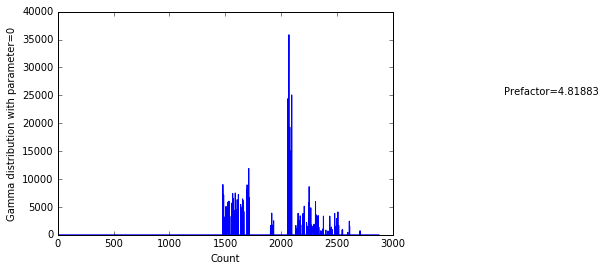

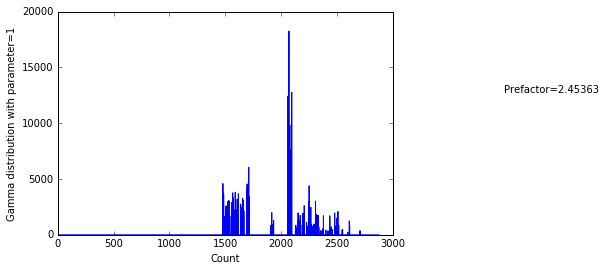

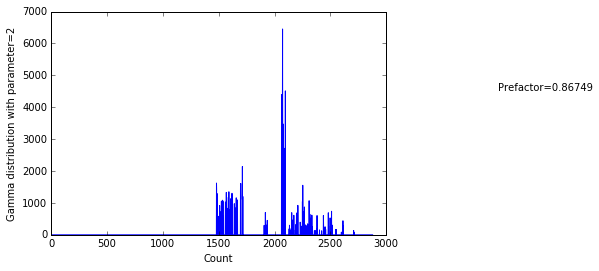

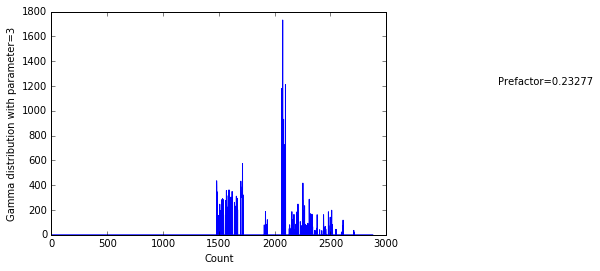

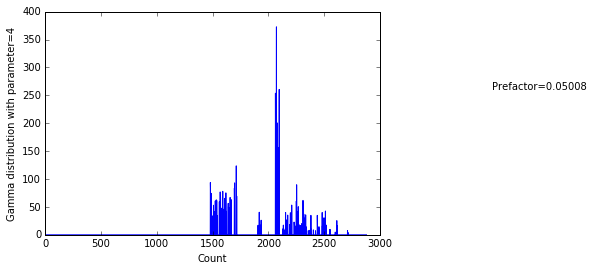

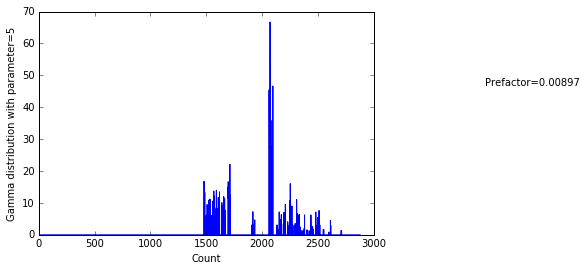

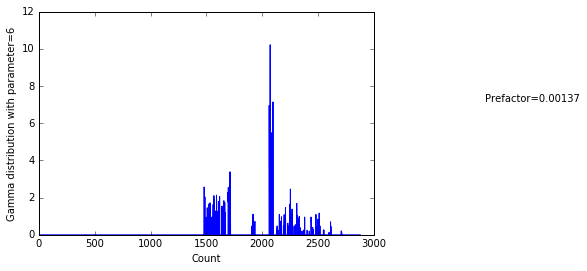

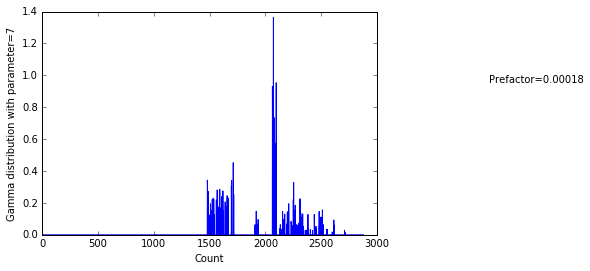

In [13]:
for kk in range(0,8):
    data[f'CDC_Lidar_gamma_{kk}'],pf=cdc_lidar_gamma(ext,ref,kk)
    plt.figure(facecolor='white')
    plt.plot(data[f'CDC_Lidar_gamma_{kk}'])
    plt.text(4000,np.max(data[f'CDC_Lidar_gamma_{kk}'])*0.7,"Prefactor="+str(round(pf,5)))
    plt.xlabel('Count')
    plt.ylabel(f'Gamma distribution with parameter={kk}')
    plt.show()

In [14]:
def cdc_lidar_exp(alpha,ref,s):
    e_coeff=np.exp((6**2)*(s**2)/2)/np.exp((2**2)*(s**2)/2)**3
    k_kw=1    
    cc=(8*(alpha**3)/(np.pi**3)*k_kw*e_coeff/ref/10**21)**0.5
    pf=(8/(np.pi**3)*k_kw*e_coeff)**0.5    
    return cc,pf

In [15]:
s=0.35
data[f'CDC_Lidar_exp_{s}'],pf=cdc_lidar_exp(ext,ref,s)

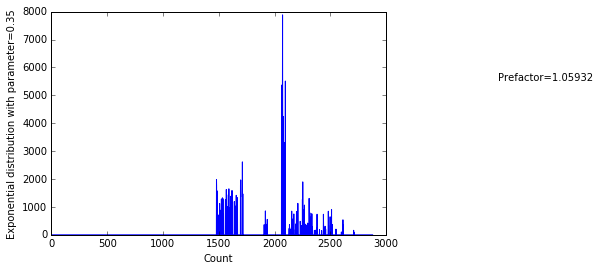

In [16]:
plt.figure(facecolor='white')
plt.plot(data[f'CDC_Lidar_exp_{s}'])
plt.text(4000,np.max(data[f'CDC_Lidar_exp_{s}'])*0.7,"Prefactor="+str(round(pf,5)))
plt.xlabel('Count')
plt.ylabel(f'Exponential distribution with parameter={s}')
plt.show()

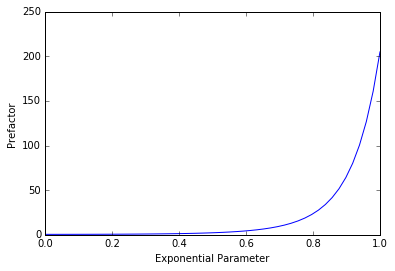

In [17]:
ss=np.linspace(1e-10,1,50)
pffs=[]
for sss in ss:
    pffs.append(cdc_lidar_exp(ext,ref,sss)[-1])
plt.plot(ss,pffs)
plt.xlabel('Exponential Parameter')
plt.ylabel('Prefactor')
plt.show()

In [18]:
data.to_csv('cdc_23072020.csv')

In [19]:
def pref(s):
    e_coeff=np.exp((6**2)*(s**2)/2)/np.exp((2**2)*(s**2)/2)**3
    k_kw=1        
    pf=(8/(np.pi**3)*k_kw*e_coeff)**0.5    
    return pf-0.23

In [20]:
from scipy.optimize import fsolve,minimize
def pos(s):
    return s-0.05
const={'type':'ineq','fun':pos}
print(const)
sol=minimize(fun=pref,x0=0.1,constraints=const)
sol

{'type': 'ineq', 'fun': <function pos at 0x000001161482C950>}


     fun: 0.28562575485441677
     jac: array([0.30937549])
 message: 'Optimization terminated successfully.'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([0.05])

### Section 4: Comparing the estimations

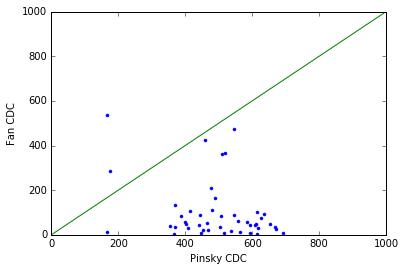

In [21]:
args=np.where(data['CDC_Fan']>0)
pts=[0,200,600,1000]
plt.figure(facecolor='white')
plt.plot(data['CDC_pinsky,k=0.5'][args[0]],data['CDC_Fan'][args[0]],'.')
plt.plot(pts,pts)
plt.ylim(0,1000)
plt.xlim(0,1000)
plt.xlabel('Pinsky CDC')
plt.ylabel('Fan CDC')
plt.show()

In [22]:
data2=data[~data.isin([np.nan, np.inf, -np.inf]).any(1)]
data2.to_csv('C:/Users/yashg/Documents/Cloud_Data_Files/CDC_0707.csv')

In [23]:
pfs=[]
ind=[]
for kk in range(0,8):
    pfs.append(cdc_lidar_gamma(ext,ref,kk)[-1])
    ind.append(f'gamma_{kk}')
ss=[1e-5,1e-3,0.05,0.1,0.35,0.5,1]
for s2 in ss:
    pfs.append(cdc_lidar_exp(ext,ref,s2)[-1])
    ind.append(f'exp_{s2}')

In [24]:
dd={'Distribution':ind,'Prefactor':pfs}
dff=pd.DataFrame(dd)
dff.style.hide_index()

Distribution,Prefactor
gamma_0,4.81883
gamma_1,2.45363
gamma_2,0.867488
gamma_3,0.232772
gamma_4,0.0500845
gamma_5,0.00896917
gamma_6,0.00137312
gamma_7,0.000183365
exp_1e-05,0.507949
exp_0.001,0.507952


In [25]:
import glob
li=[]
li=glob.glob('./varying_extinction/alldates/c/*.csv')
r=[]
for x in li:
    a1,b1=x.split('\\')
    b1=b1[:-4]
    aa=b1.split('_')
    r.append(aa[0])

In [26]:
def calculations(file,name):
    data=pd.read_csv(file)
    temp=data['Temperature']
    lwc=data['LWC']
    w=data['Velocity_SD']*0.6
    ex=data['Extinction']
    ccn=data['CCN']
    ext=data['Extinction']
    ref=10**((data['Reflectivity']-180)/10)
    ccn=data['CCN']   
    slope=[0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
    for m in slope:
        data[f'CDC_pinsky,k={m}']=CDC_pinsky(temp,ccn,w,m)
        data[f'Smax,k={m}']=Smax(temp,ccn,w,m)   
    data['CDC_Fan']=CDC_Fan(ex,lwc)
    for kk in range(0,8):
        data[f'CDC_Lidar_gamma_{kk}'],pf=cdc_lidar_gamma(ext,ref,kk)
    s=0.35
    data[f'CDC_Lidar_exp_{s}'],pf=cdc_lidar_exp(ext,ref,s)    
    data.to_csv(f'./varying_extinction/alldates/c/cdc_{name}.csv')
    return data

In [27]:
#for j in range(len(li)):
#    calculations(li[j],r[j])

In [28]:
li

['./varying_extinction/alldates/c\\20110505_15_30.csv',
 './varying_extinction/alldates/c\\20110513_15_30.csv',
 './varying_extinction/alldates/c\\20110514_15_30.csv',
 './varying_extinction/alldates/c\\20110515_15_30.csv',
 './varying_extinction/alldates/c\\20110519_15_30.csv',
 './varying_extinction/alldates/c\\20110527_15_30.csv',
 './varying_extinction/alldates/c\\cdc_20110505.csv',
 './varying_extinction/alldates/c\\cdc_20110513.csv',
 './varying_extinction/alldates/c\\cdc_20110514.csv',
 './varying_extinction/alldates/c\\cdc_20110515.csv',
 './varying_extinction/alldates/c\\cdc_20110519.csv',
 './varying_extinction/alldates/c\\cdc_20110527.csv']